In [1]:
import numpy as np
import pandas as pd
import markov
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, f1_score, log_loss, recall_score, precision_score 
! pip install scikit-plot
import scikitplot as skplt
import re
import os

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from torch.utils.data import Dataset,DataLoader
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import torch.nn as nn
import torch.optim as optim
import math

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [2]:
data1 = pd.read_csv("./Datasets/master_dataset.csv").fillna(' ')

In [3]:
df = data1[data1.label_sexist == 'sexist']
ndf = data1[data1.label_sexist == 'not sexist']
add_df = ndf.sample(2000)
frames = [add_df,df]
data = pd.concat(frames)

In [4]:
def clean_text(text):
    """Removes HTML tags and removes punctuation from the text"""
    text = text.lower() #lower case
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'www\S+', '', text)  # remove www website
    text = re.sub(r'<.*?>', '', text)  # remove html tags
    text = re.sub(r'[^\w\s]', '', text) # remove special characters like !,@,#,$,%
    text = re.sub('\s+', ' ', text) # replace multiple space by single space
    return text

def remove_stopword(text, stopwords):
    """Removes common words such as "the" and "a" from the text"""    
    return " ".join([word for word in text.split() if word not in (stop_words)])
  
def lemma_text(text, lemmatizer):
    """Reduces words to their base forms using lemmatization"""
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenize(text)]
    return " ".join(lemmatized_words)

def stem_text(text, stemmer):
    """Reduces words to their base forms using the provided stemmer"""
    stemmed_words = [stemmer.stem(word) for word in tokenize(text)]
    return " ".join(stemmed_words)

def tokenize(text):
    """Splits the text into individual words"""
    return text.split()

def process_text(text, lemmatizer, stemmer, stop_words):
    text = clean_text(text)
    text = remove_stopword(text, stop_words)
    #text = lemma_text(text, lemmatizer)
    #text = stem_text(text, stemmer)
    return text #tokenize(text) #START_TOKEN + " ".join(tokenize(text)) + STOP_TOKEN
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [5]:
# stores the result in a new column called 'processed_text'
data["processed_text"] = data['text'].apply(process_text, lemmatizer = lemmatizer, stemmer = stemmer, stop_words = stop_words)
data.head(5)

,text,label_sexist,processed_text
3589,"Hell, she just says what lots of fems think.",not sexist,hell says lots fems think
13858,"Nice, I'm looking for a photo of a babe pointi...",not sexist,nice im looking photo babe pointing ump45 hips...
13613,LMAO 😂 BROOO.....honestly I hope a nigga tells...,not sexist,lmao brooohonestly hope nigga tells get slim i...
1565,"Hold onto your hats ladies and gentlemen, this...",not sexist,hold onto hats ladies gentlemen ride get littl...
12170,But she will be queen of the cats! All 32 of t...,not sexist,queen cats 32 see rules throne cat piss


In [6]:
train_X, test_X, train_Y, test_Y = train_test_split(data['processed_text'], data['label_sexist'],stratify=data['label_sexist'], test_size=0.25)

In [7]:
labels = [str(i).split('/') for i in train_Y]
text= train_X

In [8]:
"""The code creates a Tf-idf vectorizer with a minimum document frequency of 5, 
applies it to a list of texts, then creates a multilabel binarizer and 
fits it to a list of labels. It creates arrays for the input and output features, and 
splits the data into training and test sets"""

tfidfvectorizer = TfidfVectorizer(min_df = 5) #max_features=3000
x_tfidf = tfidfvectorizer.fit_transform(text).toarray()
mlb = MultiLabelBinarizer()
mlb.fit(labels)
Y = mlb.transform(labels)
n_op_features = len(Y[0])
train_x,test_x,train_y,test_y = train_test_split(x_tfidf,Y,test_size=0.2)
n_ip_features = len(train_x[0])

In [9]:
class TextDataset(Dataset):
  '''This code block converts the arrays into tensors for pytorch.'''
  def __init__(self, X, y):
    self.X = torch.tensor(X)
    self.y = torch.tensor(y)
  def __len__(self):
    return len(self.y)
  def __getitem__(self,index):
    return self.X[index], self.y[index]

In [10]:
# DataLoader Definition
batch_size = 128
train_ds = TextDataset(X=train_x, y=train_y)
test_ds = TextDataset(X=test_x, y=test_y)
dataloader_train = DataLoader(dataset=train_ds,batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

In [11]:
class MLP(nn.Module):
  '''Multi-layered perceptron based classifier'''
  def __init__(self, num_features,out_features):
    """
    Args:
        num_features (int): the size of the input feature vector
    """
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(in_features=num_features, out_features=64)
    print("num f:", num_features)
    self.fc2 = nn.Linear(in_features=64,out_features=32)
    self.fc3 = nn.Linear(in_features=32,out_features=out_features)

  def forward(self, x_in, apply_softmax=False):
    """The forward pass of the classifier
    
    Args:
        x_in (torch.Tensor): an input data tensor. 
            x_in.shape should be (batch, num_features)
        apply_softmax (bool): a flag for the sigmoid activation
            should be false if used with the Cross Entropy losses
    Returns:
        the resulting tensor. tensor.shape should be (batch,)
    """
    y_out_1 = torch.relu(self.fc1(x_in))
    y_out_2 = self.fc2(y_out_1)
    y_out = self.fc3(y_out_2)
    return y_out

In [12]:
# CUDA
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [13]:
from markov import Project, ProjectScope

# Create a new project
my_project = Project(
    # project name
    name="Test project_5",
    # project description (optional)
    description="Testing a project feature",
    # project visibility (optional; public by default)
    project_scope=ProjectScope.PUBLIC,
)

✔ Creating Project with name Test project_5 Project created successfully.


In [15]:
# Training the model
learning_rate=0.0001
num_epochs=40
hyper_parameters = {"learning_rate":0.0001,"num_epochs":40}
epoch_loss_list=[]
epoch_acc_list=[]
val_epoch_acc_list=[]
val_epoch_loss_list=[]

model = MLP(n_ip_features,n_op_features)
model.to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_iter=math.ceil(len(train_ds)/batch_size)
print(n_iter)


# Use the ExperimentRecorder constuctor provided by the MarkovML SDK
# to create a new experiment recorder
recorder = markov.ExperimentRecorder(
    # Name of the experiment recording
    name="Test_Experiment_12",
    # Project associated with the experiment
    project_id=my_project.project_id,
    # project_id="3Tfz2jR4xNF23H",
    # Hyper-parameters used for model training
    hyper_parameters = {"learning_rate":0.0001,"num_epochs":40},
    # Additional notes (optional)
    model_class=markov.ModelClass.TAGGING,
    notes="This is a test experiment"
)

num f: 2002
37
✔ Creating Model Model creation successful!
✔ Registering Hyper Parameter Recorder with Markov Backend. Recorder successfully registered.
ℹ You can view the experiment at \https://app.markovml.com/wsp-27m23rbvum/proj/38MgTudXeG7cA5/experiments/hp-3VAfL68JtrXGqKhH9LrrzwK]8;;\


In [16]:
losses = []
with recorder:
    for epoch in range(num_epochs):
      epoch_loss = 0
      epoch_acc=0
      val_epoch_loss=0
      val_epoch_acc=0
      for k,(X,y) in enumerate(dataloader_train):
        # the training routine is these 5 steps:

        # step 1. load the data
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = model(x_in=X.float())
        y_1 = (y_pred).to('cpu').detach().numpy()
        y_1=(np.array(y_1) >= 0)*1
        y_0=y.to('cpu').detach().numpy()
        acc = sum([(y_0[i]==y_1[i]).all()*1 for i in range(len(y_0))])
        epoch_acc+= acc
        # recorder.add_record({"accuracy": acc})
        # recorder.add_record({"accuracy per epoch": epoch_acc})

    # step 3. compute the loss
        loss = loss_func(y_pred, y.squeeze(1).float())
        # recorder.add_record({"loss": loss})
        epoch_loss+= loss.item()

    # step 4. use loss to produce gradients
        loss.backward()

    # step 5. use optimizer to take gradient step
        optimizer.step()
      epoch_loss = round(epoch_loss/(k+1),3)
      epoch_loss_list.append(epoch_loss)
      epoch_acc = round(epoch_acc/len(train_ds),3)
      epoch_acc_list.append(epoch_acc)
  
      for k,(X,y) in enumerate(dataloader_test):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(x_in=X.float())
        y_1 = (y_pred).to('cpu').detach().numpy()
        y_1=(np.array(y_1) >= 0)*1
        y_0=y.to('cpu').detach().numpy()
        val_acc = sum([(y_0[i]==y_1[i]).all()*1 for i in range(len(y_0))])
        # recorder.add_record({"val_acc": val_acc})
        val_epoch_acc+=val_acc
        # recorder.add_record({"val_accuracy per epoch": val_epoch_acc})
        loss = loss_func(y_pred, y.squeeze(1).float())
        # recorder.add_record({"loss2": loss})
        val_epoch_loss+= loss.item()
        # recorder.add_record({"loss per epoch": val_epoch_loss})

      val_epoch_acc=round(val_epoch_acc/len(test_ds),3)
      val_epoch_acc_list.append(val_epoch_acc)
      val_epoch_loss = round(val_epoch_loss/(k+1),3)
      val_epoch_loss_list.append(val_epoch_loss)
      print('epoch : ' + str(epoch+1)+'/'+str(num_epochs))
      print("-"*40)
      print('loss : ' + str(epoch_loss)+ ' \t val loss : '+ str(val_epoch_loss)+ '\nacc :' + str(epoch_acc)+ ' \t val acc :' + str(val_epoch_acc))
      print("+"*40)  # -----------------------------------------
      losses.append(epoch_loss)
      recorder.add_record({"loss": epoch_loss})
      recorder.add_record({"val_loss": val_epoch_loss})
      recorder.add_record({"accuracy": epoch_acc})
      recorder.add_record({"val_accuracy": val_epoch_acc})

ℹ Starting recorder to track training data on markov backend.
epoch : 1/40
----------------------------------------
loss : 0.677 	 val loss : 0.674
acc :0.75 	 val acc :0.722
++++++++++++++++++++++++++++++++++++++++
epoch : 2/40
----------------------------------------
loss : 0.67 	 val loss : 0.67
acc :0.75 	 val acc :0.722
++++++++++++++++++++++++++++++++++++++++
epoch : 3/40
----------------------------------------
loss : 0.66 	 val loss : 0.66
acc :0.75 	 val acc :0.722
++++++++++++++++++++++++++++++++++++++++
epoch : 4/40
----------------------------------------
loss : 0.648 	 val loss : 0.651
acc :0.75 	 val acc :0.722
++++++++++++++++++++++++++++++++++++++++
epoch : 5/40
----------------------------------------
loss : 0.633 	 val loss : 0.635
acc :0.75 	 val acc :0.722
++++++++++++++++++++++++++++++++++++++++
epoch : 6/40
----------------------------------------
loss : 0.615 	 val loss : 0.616
acc :0.75 	 val acc :0.722
++++++++++++++++++++++++++++++++++++++++
epoch : 7/40
-----

In [17]:
def plot_graph(plot_var,train_plot_list,val_plot_list):
  '''Function for visualizing the Accuracy and Loss'''
  epochs = len(train_plot_list)
  fig = plt.figure(figsize=(8,6))
  if plot_var=="accuracy": plt.title("Train/Validation Accuracy")
  elif plot_var =="loss" : plt.title("Train/Validation Loss")
  plt.plot(list(np.arange(epochs) + 1) , train_plot_list, label='train')
  plt.plot(list(np.arange(epochs) + 1), val_plot_list, label='validation')
  plt.xlabel('num_epochs', fontsize=12)
  plt.ylabel('loss', fontsize=12)
  plt.legend(loc='best')
  if plot_var=="accuracy": plt.savefig("./result/task_a_train_Val_accuracy.png")
  elif plot_var =="loss" : plt.savefig("./result/task_a_train_Val_loss.png")
  return

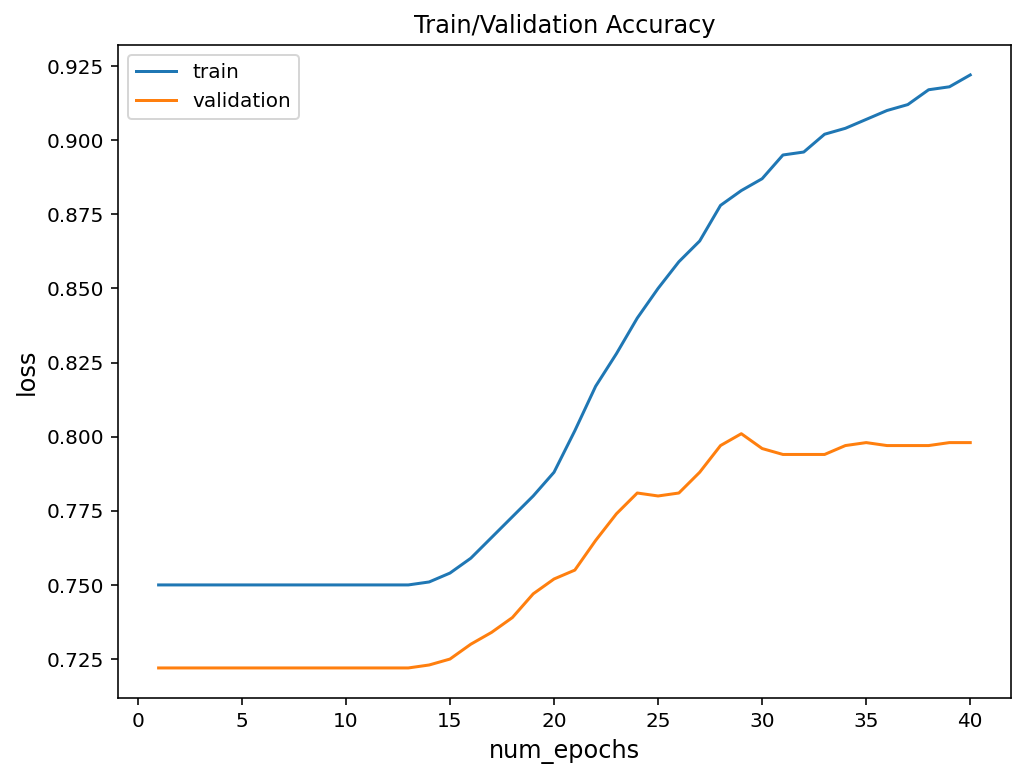

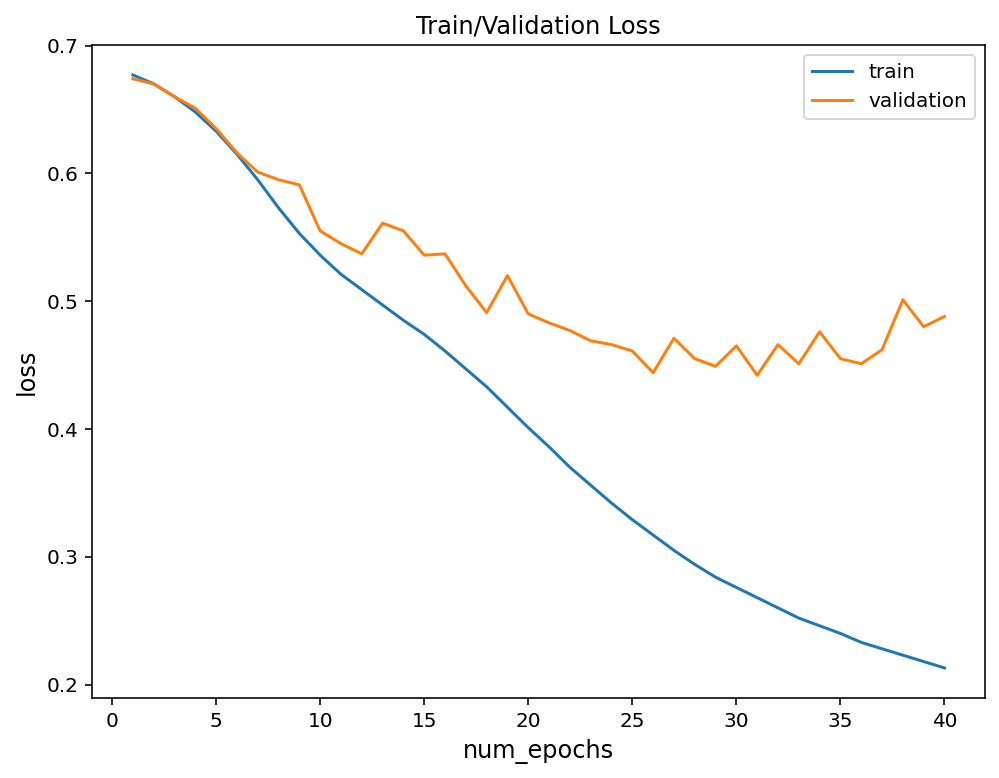

In [18]:
# visualizing the Accuracy and Loss
plot_graph("accuracy",epoch_acc_list, val_epoch_acc_list)
plot_graph("loss",epoch_loss_list, val_epoch_loss_list)

In [19]:
# Converting testing elements to torch tensor from array
test_x = torch.Tensor(test_x)
y_pred = model(test_x.to(device)) 
print(y_pred.shape, test_x.shape)

torch.Size([1175, 2]) torch.Size([1175, 2002])


In [20]:
def multilabel_predict(x):
  '''Function to get predicted labels for testing data'''
  x = tfidfvectorizer.transform([x]).toarray()
  x = torch.tensor(x, dtype=torch.float64)
  pred = model(x_in=x.float().to(device))
  y_1 = (pred).to('cpu').detach().numpy()
  ind=(y_1).argmax(axis = 1)
  y_dim = y_1.shape[1]
  l = [0 for i in range(y_dim)]
  for i in range(y_dim):
      if i==ind:
          l[i] = 1
  #y_1 = np.array(l)
  #print(y_1)
  y_1 = mlb.inverse_transform(np.array(l).reshape(1,2))
  return y_1

In [21]:
# Getting relations for plotting Confusion Matrix
test_utterences= test_X
predicted_relations=[]
for utterence in test_utterences:
  test_pred=multilabel_predict(utterence)
  predicted_relations.append(test_pred[0])
print(len(predicted_relations))

1958


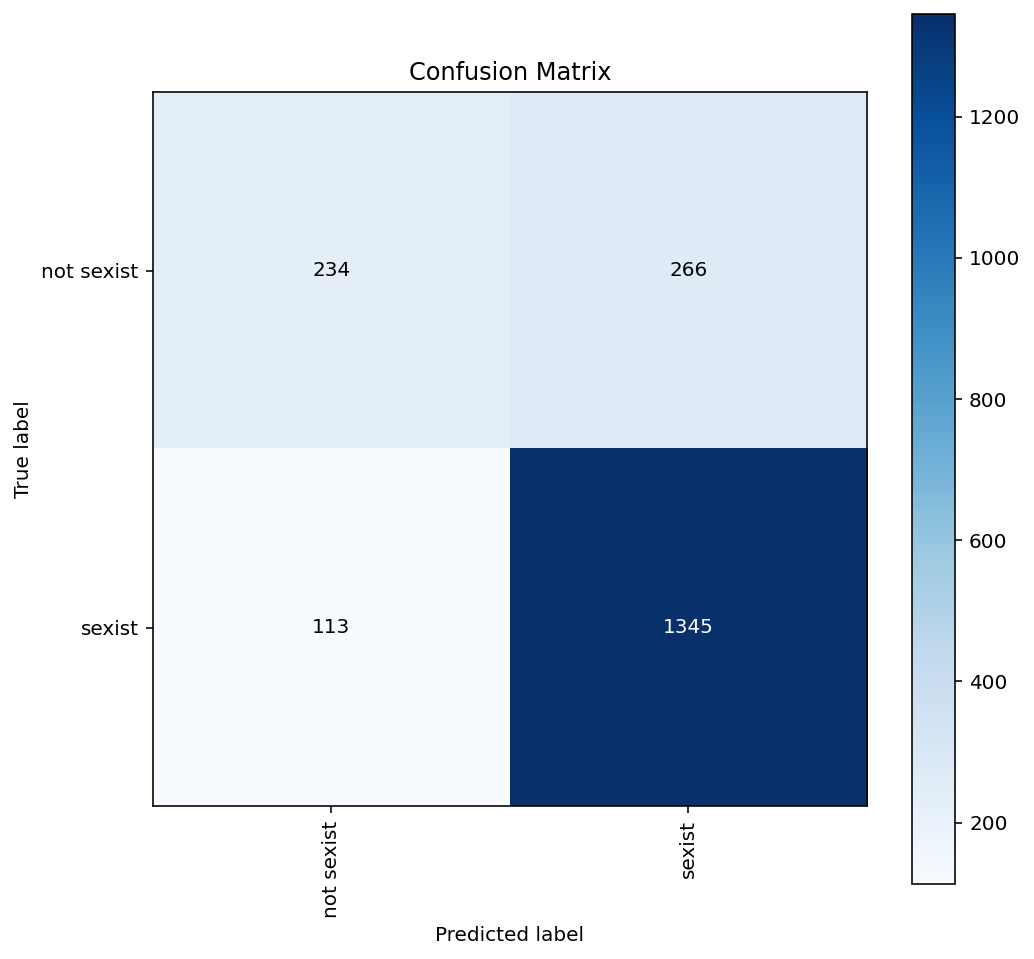

In [23]:
# Plotting Confusion Matrix
y_true = [x for x in test_Y]
y_pred = [x for x in predicted_relations]
skplt.metrics.plot_confusion_matrix(y_true, y_pred, figsize=(8,8),x_tick_rotation=90)
plt.savefig("./result/task_a_confusion_matrix.png")

In [24]:
# Evaluation Report
print(classification_report(y_true,y_pred))
clsf_report = pd.DataFrame(classification_report(y_true,y_pred, output_dict=True)).transpose()
clsf_report.to_csv("./result/task_a_classification_report.csv", index= True)

              precision    recall  f1-score   support

  not sexist       0.67      0.47      0.55       500
      sexist       0.83      0.92      0.88      1458

    accuracy                           0.81      1958
   macro avg       0.75      0.70      0.71      1958
weighted avg       0.79      0.81      0.79      1958



In [25]:
dict_data = {'actual': y_true, 'predicted': y_pred} ## see which variables to take from accuracy_score line in previous code block
df_markov = pd.DataFrame(data=dict_data)
# df_markov.replace({'not_sexist': 0, 'sexist': 1}, inplace=True)
df_markov.to_csv("recording_model2.csv")
df_markov.head()

# now just map the not sexist with 0 and sexist with 1

,actual,predicted
0,sexist,"(sexist,)"
1,sexist,"(sexist,)"
2,sexist,"(sexist,)"
3,sexist,"(sexist,)"
4,sexist,"(sexist,)"


In [26]:
torch.save(model.state_dict(), "trained_model2.pth")

In [28]:
model.load_state_dict(torch.load('trained_model2.pth'))

<All keys matched successfully>

In [32]:
def predict_sexism(x):
  x = tfidfvectorizer.transform([x]).toarray()
  x = torch.tensor(x, dtype=torch.float64)
  model.load_state_dict(torch.load('trained_model2.pth'))
  pred = model(x_in=x.float().to(device))
  y_1 = (pred).to('cpu').detach().numpy()
  ind=(y_1).argmax(axis = 1)
  y_dim = y_1.shape[1]
  l = [0 for i in range(y_dim)]
  for i in range(y_dim):
      if i==ind:
          l[i] = 1
  y_1 = mlb.inverse_transform(np.array(l).reshape(1,2))
  return y_1

In [45]:
t1 = "women are weak and inferior"

In [46]:
test_pred=predict_sexism(t1)
print(test_pred)

[('sexist',)]


In [47]:
from markov import EvaluationRecorder
evaluation_recorder = EvaluationRecorder(
    name=f"Evaluating model {recorder.name}",
    notes=f"Testing evaluation with MarkovML",
    model_id=recorder.model_id
)

evaluation_recorder.register()

In [49]:
import os
import uuid

from markov.api.schemas.model_recording import SingleTagInferenceRecord

# create and register the recorder
filepath = os.path.join('recording_model2.csv')
with open(filepath) as f:
    for line in f:
        # Assign a unique identifier for individual records
        record_id = str(uuid.uuid4())
        tokens = line.strip('\n').split(',')
        record = SingleTagInferenceRecord(
            urid=record_id,
            inferred=tokens[2],
            actual=tokens[1],
            score=float(tokens[0])
        )
        evaluation_recorder.add_record(record)
outcome = evaluation_recorder.finish()
print(outcome)

Upload Progress : 100%|██████████| 2/2 [00:00<00:00,  2.07batch/s]


EvaluationRecordingFinishResponse(count=1958, recording_id='3GVQwTeVFyJHRpWzGWEZUcw', return_code='OK', message='', run_id='Ffok7XYPo93kaFSP4h7')
